## Setup

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/WignerMolecule.jl/analysis`


Status `~/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.8
⌃ [780c37f4] Carlo v0.2.6
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.1
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.3
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.16
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using HDF5
using JLD2
using LinearAlgebra

In [3]:
function etak_tranform(etak_corrs)
    result = map(Iterators.product(1:3, 1:3)) do (x, y)
        etak_corrs[:, :, x, y]
    end
    return reshape(result, (9,))
end

function separate_etaks!(data::AbstractDataFrame)
    col_names = [:ηk_xx, :ηk_yx, :ηk_zx, :ηk_xy, :ηk_yy, :ηk_zy, :ηk_xz, :ηk_yz, :ηk_zz]
    transform!(
        data,
        :etak_corrs => (corrs -> etak_tranform.(corrs)) => col_names
    )
    return nothing
end

separate_etaks! (generic function with 1 method)

In [4]:
get_M_point(corrs) = corrs[size(corrs, 1) ÷ 2 + 1]

get_M_point (generic function with 1 method)

In [5]:
function gen_path(Lx, Ly)
    pos = (1, 1)
    path = [pos]
    while pos[1] < div(Lx, 2) + 1
        pos = pos .+ (1, 0)
        push!(path, pos)
    end
    M_pos = length(path)
    while pos[2] < div(Ly, 3, RoundNearest) + 1
        pos = pos .+ (1, 2)
        push!(path, pos)
    end
    K_pos = length(path)
    while pos[1] > 2
        pos = pos .- (2, 1)
        push!(path, pos)
    end
    return (path, M_pos, K_pos)
end

gen_path (generic function with 1 method)

In [6]:
function generatePlot(data::AbstractDataFrame, x, y;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    vals = getfield.(data[:, y], :val)
    errs = getfield.(data[:, y], :err)
    scatter!(data[:, x], vals)
    if line
        lines!(data[:, x], vals)
    end
    errorbars!(data[:, x], vals, errs)

    return ax
end

function generatePlot(data::AbstractDataFrame, x, ys::Vector;
                      title="", xlabel="", ylabel="", line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for (label, y) in zip(ys, eachcol(data[:, ys]))
        vals = getfield.(y, :val)
        errs = getfield.(y, :err)
        scatter!(data[:, x], vals; label="$label")
        if line
            lines!(data[:, x], vals)
        end
        errorbars!(data[:, x], vals, errs)
    end
    axislegend()

    return ax
end

function generatePlot(data::GroupedDataFrame, x, y;
                      title, xlabel, ylabel, line=false)
    ax = Axis(fig; title, xlabel, ylabel)

    for key in keys(data)
        group = data[key]
        vals = getfield.(group[:, y], :val)
        errs = getfield.(group[:, y], :err)
        scatter!(group[:, x], vals, label="$(NamedTuple(key))")
        if line
            lines!(group[:, x], vals)
        end
        errorbars!(group[:, x], vals, errs)
    end

    axislegend()

    return ax
end

generatePlot (generic function with 3 methods)

## Ground State Initialization

In [22]:
results = JobResult("../jobs", "fm")
separate_etaks!(results.data)
transform!(results.data, :spink_corrs => (v -> get_M_point.(v)) => :spink_M)
results

JobResult("../jobs", "fm", 42×38 DataFrame
 Row │ ηz               T        etak_corrs                         _ll_sweep_ ⋯
     │ Measurem…        Float64  Array…                             Measurem…  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.988957±4.3e-5      0.5  Complex{Measurement{Float64}}[1.…  0.00041313 ⋯
   2 │ 0.977438±6.5e-5      1.0  Complex{Measurement{Float64}}[2.…  0.00041430
   3 │ 0.96529±0.00011      1.5  Complex{Measurement{Float64}}[4.…  0.00060969
   4 │ 0.952222±9.0e-5      2.0  Complex{Measurement{Float64}}[6.…  0.00041612
   5 │ 0.93819±0.00013      2.5  Complex{Measurement{Float64}}[7.…  0.00041769 ⋯
   6 │ 0.92321±0.0002       3.0  Complex{Measurement{Float64}}[9.…  0.00041716
   7 │ 0.90647±0.00023      3.5  Complex{Measurement{Float64}}[0.…  0.0004173±
   8 │ 0.88673±0.00036      4.0  Complex{Measurement{Float64}}[0.…  0.00042047
  ⋮  │        ⋮            ⋮                     ⋮                          ⋮ 

In [23]:
results[[:_ll_sweep_time, :_ll_measure_time]]

42×2 DataFrame
 Row │ _ll_sweep_time      _ll_measure_time 
     │ Measurement…        Measurement…     
─────┼──────────────────────────────────────
   1 │ 0.000413138±5.8e-8  0.000175±1.4e-5
   2 │ 0.000414303±5.3e-8  0.000175±1.4e-5
   3 │ 0.00060969±1.6e-7   0.00025±1.8e-5
   4 │ 0.000416126±6.8e-8  0.000175±1.3e-5
   5 │ 0.000417694±8.4e-8  0.00018±1.8e-5
   6 │ 0.000417169±6.1e-8  0.000175±1.4e-5
   7 │ 0.0004173±4.6e-7    0.000176±1.3e-5
   8 │ 0.000420472±6.2e-8  0.000188±1.3e-5
  ⋮  │         ⋮                  ⋮
  36 │ 0.0066698±4.0e-6    0.0021585±3.1e-6
  37 │ 0.00664898±5.1e-7   0.0021675±3.3e-6
  38 │ 0.0066639±4.8e-7    0.0021584±3.2e-6
  39 │ 0.0067282±9.1e-6    0.0023662±4.8e-6
  40 │ 0.0067503±2.6e-6    0.0023455±3.7e-6
  41 │ 0.00829±0.00044     0.00264±0.00013
  42 │ 0.0084±0.00044      0.00265±0.00013
                             27 rows omitted

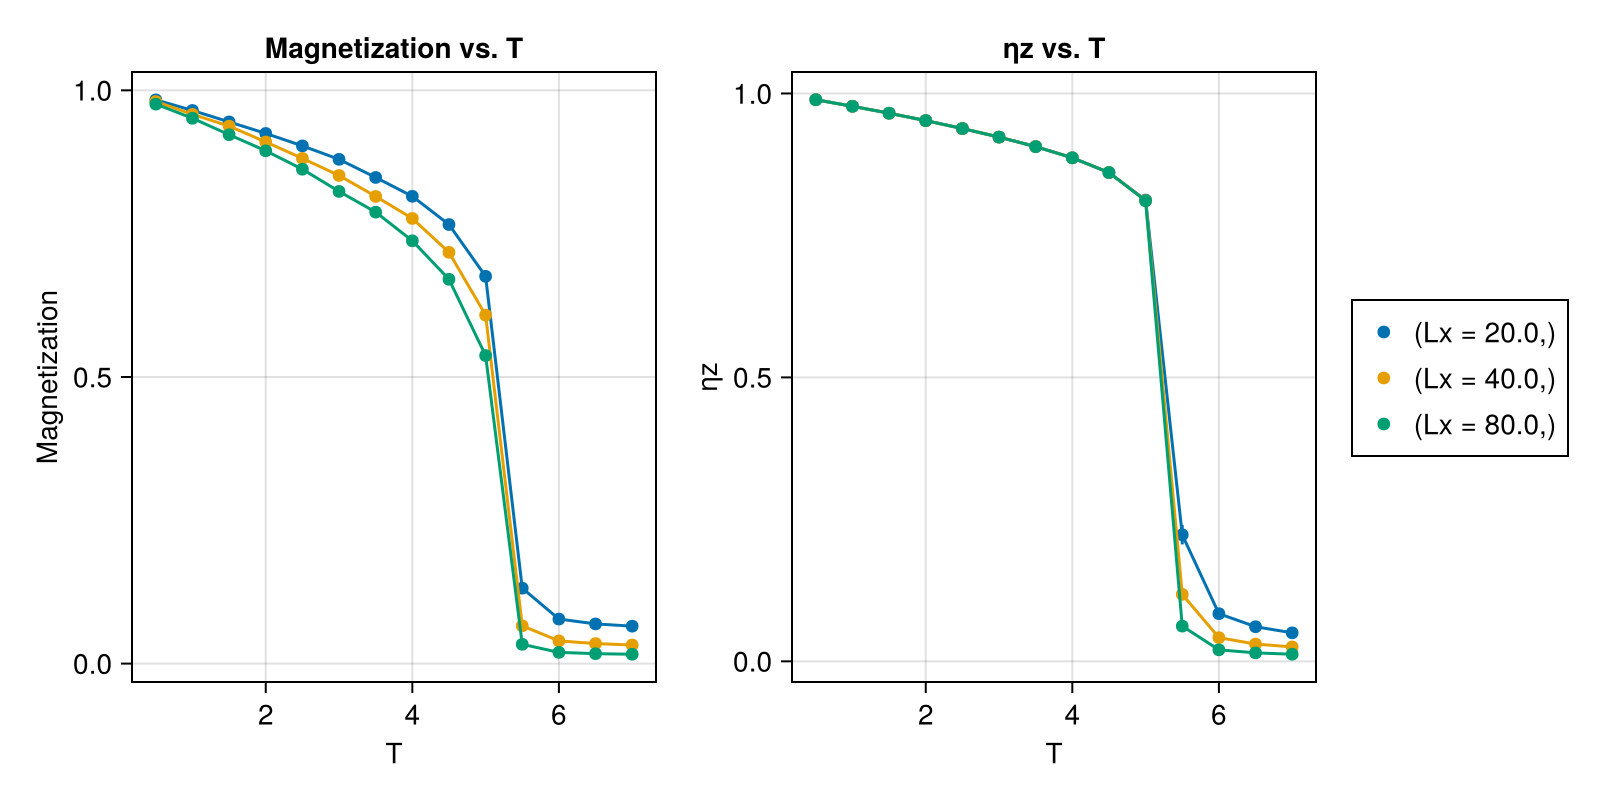

In [24]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Magnetization vs. T", xlabel="T", ylabel="Magnetization")
# scatter!(ax1, results[:B], M_points)
# lines!(ax1, results[:B], M_points)
generate_plot!(ax1, :T, :Mag, [:Lx], results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="ηz vs. T", xlabel="T", ylabel="ηz")
generate_plot!(ax2, :T, :ηz, [:Lx], results.data; line=true)
Legend(fig[1,3], ax2)
fig

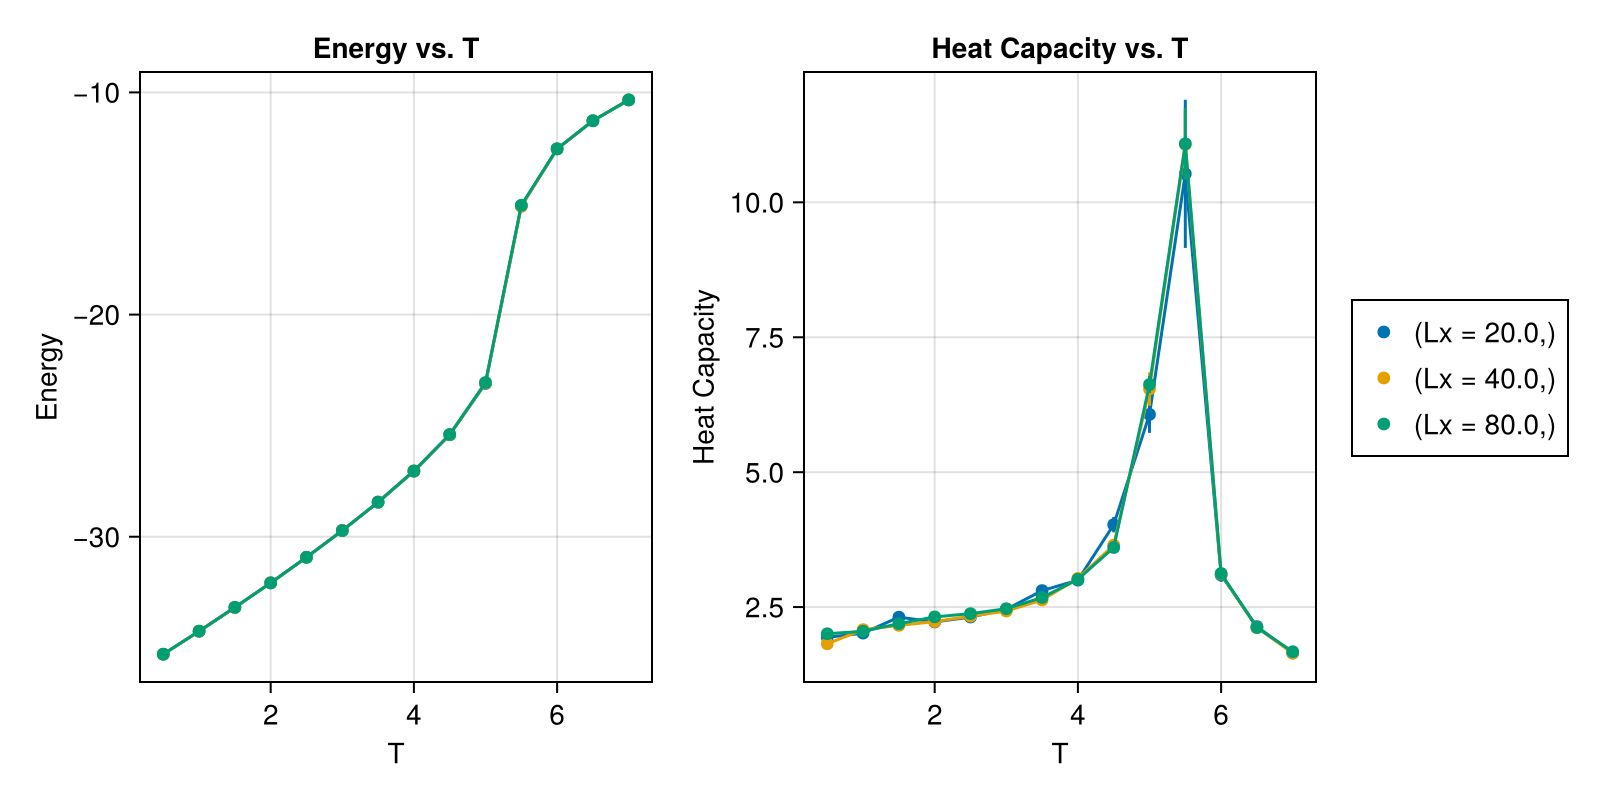

In [35]:
fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Energy vs. T", xlabel="T", ylabel="Energy")
generate_plot!(ax1, :T, :Energy, [:Lx], results.data; line=true)
ax2 = fig[1,2] = Axis(fig, title="Heat Capacity vs. T", xlabel="T", ylabel="Heat Capacity")
generate_plot!(ax2, :T, :HeatCap, [:Lx], results.data; line=true)
Legend(fig[1,3], ax1)
fig

In [26]:
mctimes = get_mctime_data(results, :etak_corrs, :ηz)
separate_etaks!.(mctimes)
mctimes

42-element Vector{DataFrame}:
 100×11 DataFrame
 Row │ etak_corrs                         ηz              ηk_xx                ⋯
     │ SubArray…                          SubArray…       Array…               ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ComplexF64[1.63005e-5+0.0im 1.22…  fill(0.989004)  ComplexF64[1.63005e- ⋯
   2 │ ComplexF64[1.05802e-5+0.0im 1.75…  fill(0.988511)  ComplexF64[1.05802e-
   3 │ ComplexF64[9.91778e-6+0.0im 1.32…  fill(0.989492)  ComplexF64[9.91778e-
   4 │ ComplexF64[8.5697e-6+0.0im 1.577…  fill(0.989736)  ComplexF64[8.5697e-6
   5 │ ComplexF64[1.24617e-5+0.0im 1.31…  fill(0.988895)  ComplexF64[1.24617e- ⋯
   6 │ ComplexF64[1.22326e-5+0.0im 1.07…  fill(0.988774)  ComplexF64[1.22326e-
   7 │ ComplexF64[5.7298e-6+0.0im 9.039…  fill(0.989235)  ComplexF64[5.7298e-6
   8 │ ComplexF64[1.04539e-5+0.0im 1.14…  fill(0.989561)  ComplexF64[1.04539e-
  ⋮  │                 ⋮                        ⋮                        

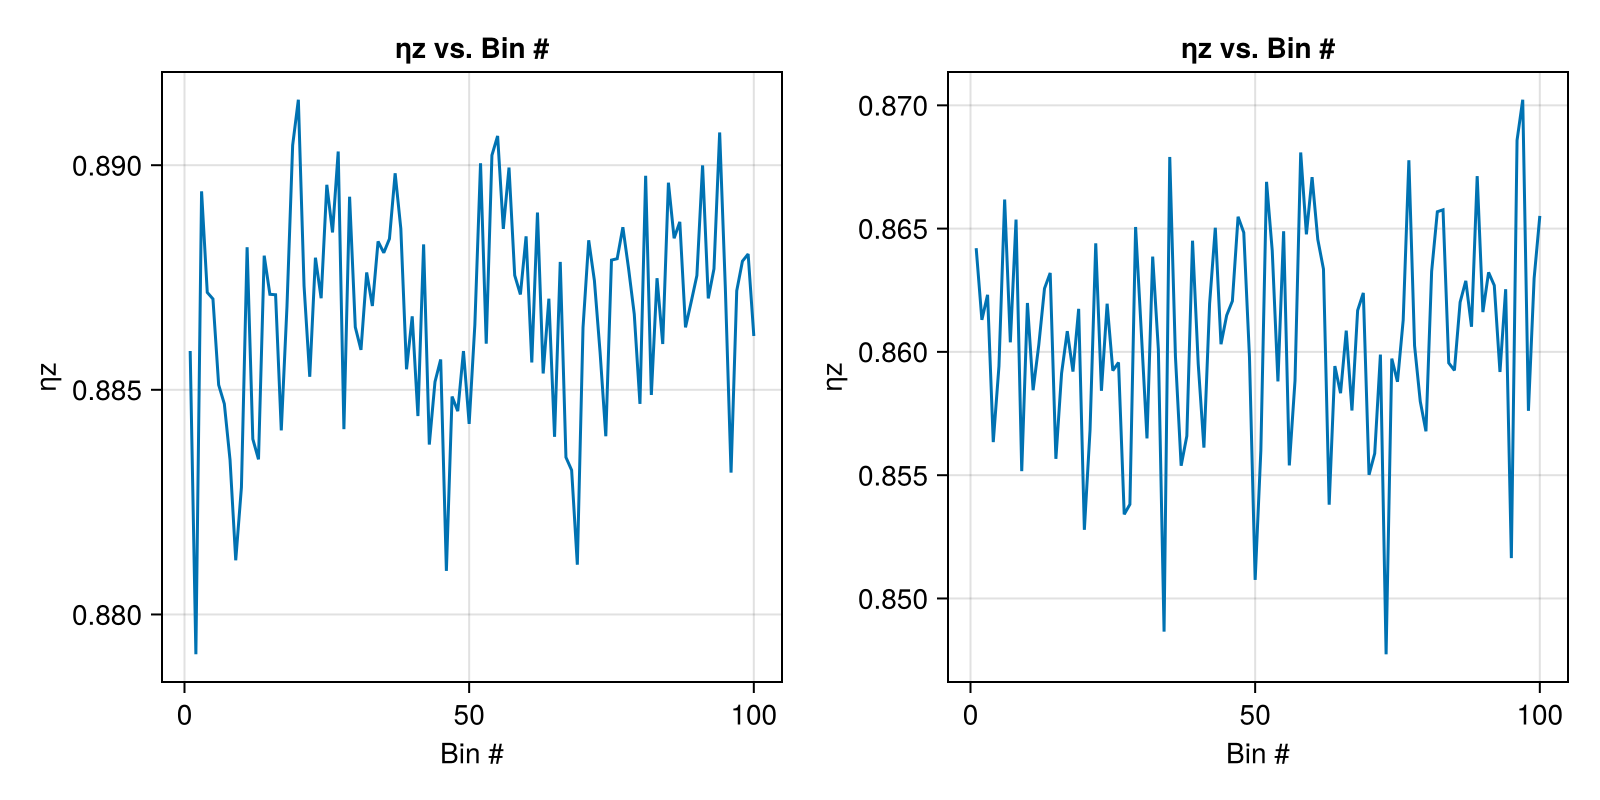

In [27]:
CairoMakie.activate!()
i = 8
k_pos = (1, 1)

var1 = :ηz
var2 = :ηz
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(first.(mctimes[i][:, var1])))
lines!(ax2, abs.(first.(mctimes[i+1][:, var2])))
fig

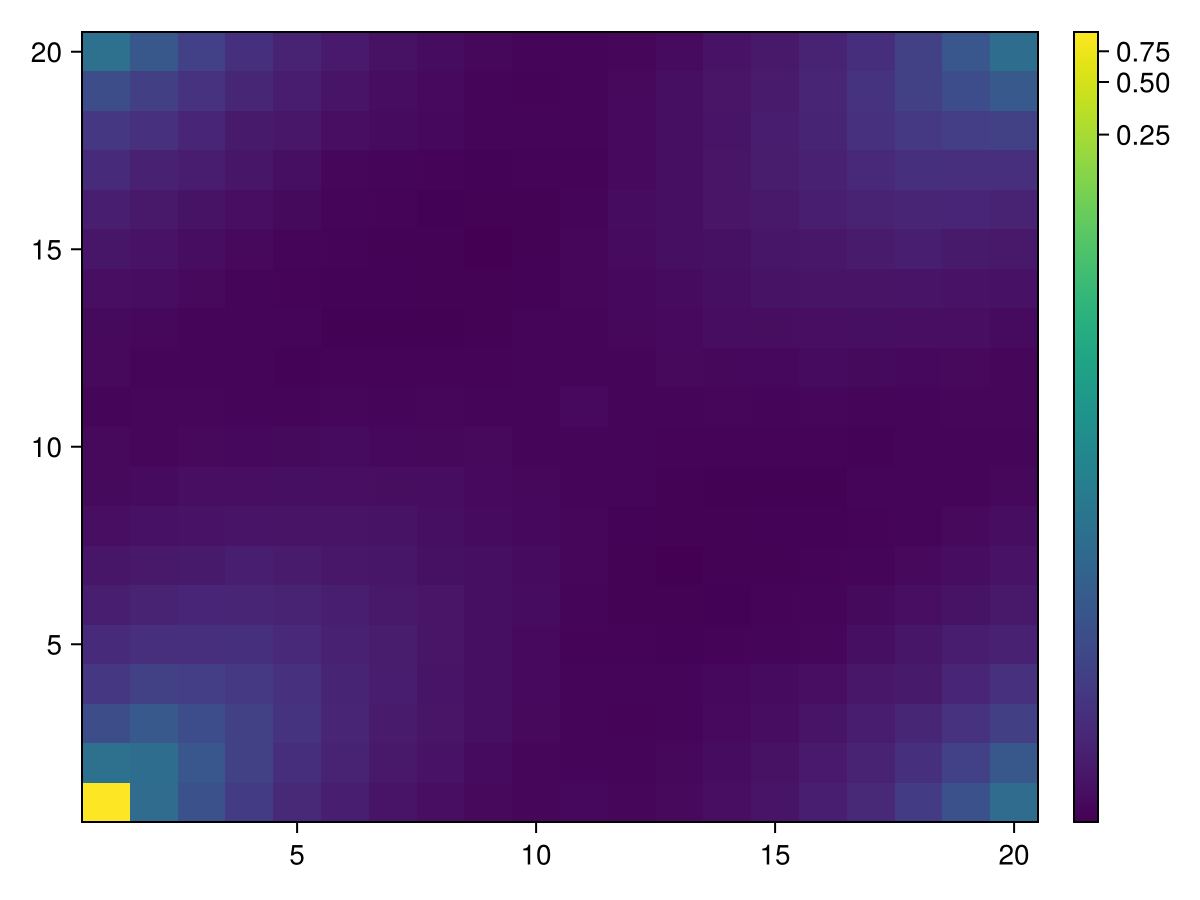

In [28]:
CairoMakie.activate!()
spink_corrs = results[:spink_corrs]
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[1], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

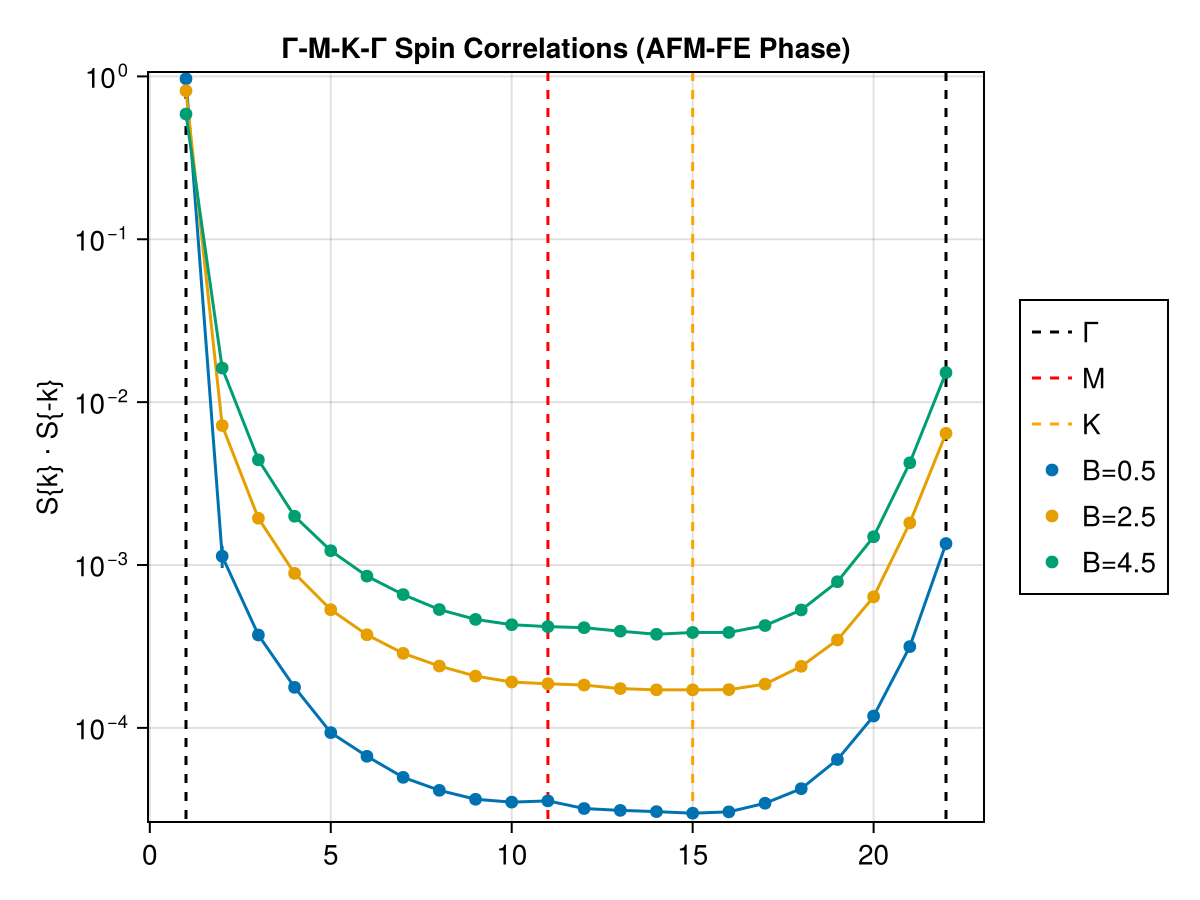

In [29]:
CairoMakie.activate!()
spink_corrs = results[:spink_corrs]
is = [1, 5, 9]

spink_corrs = results[:spink_corrs]
Bs = results[:T]
path, M_pos, K_pos = gen_path(size(spink_corrs[1])...)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_border, max_border))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (19, 10), (17, 9), (15, 8), (13, 7), (14, 6), (15, 5), (16, 4), (17, 3), (18, 2), (19, 1)]


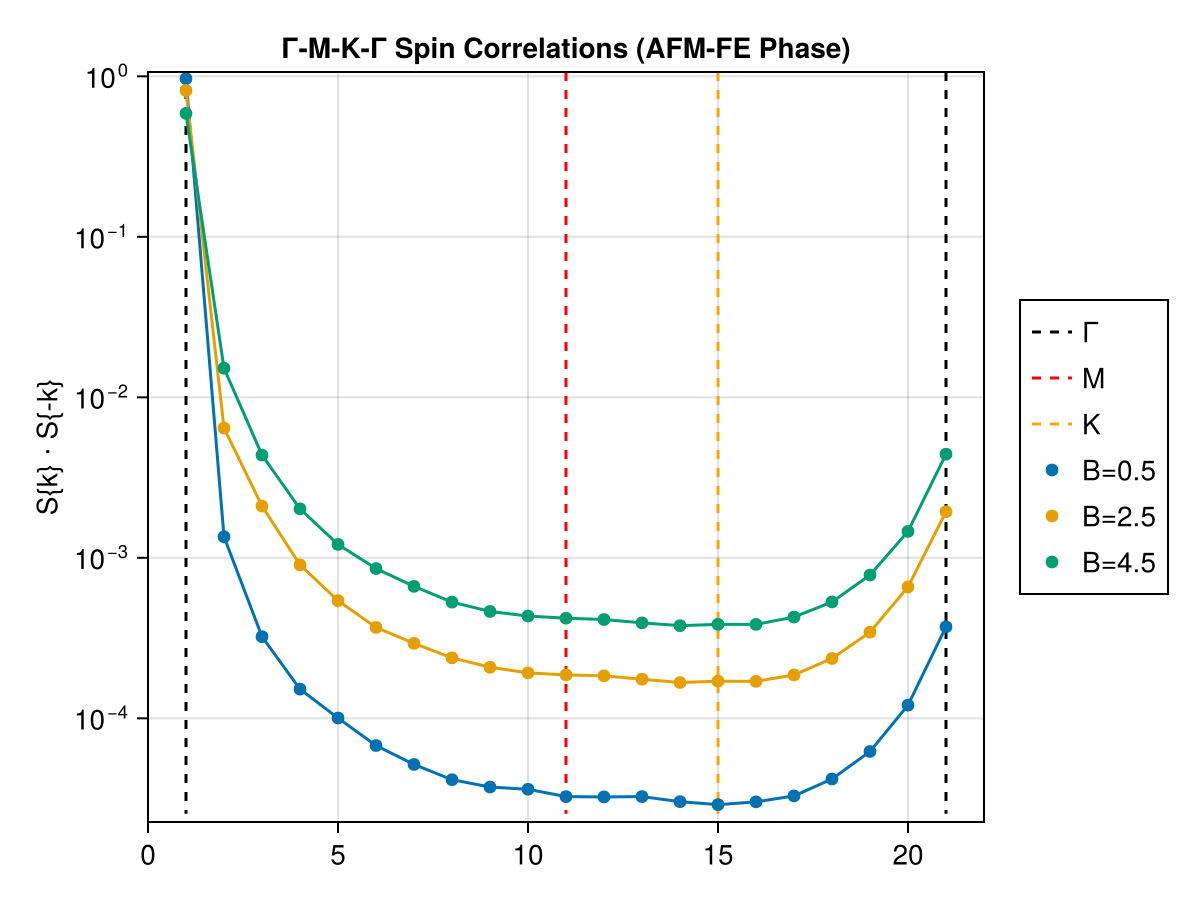

In [30]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] < div(Ly, 2) + 1
    pos = pos .+ (0, 1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[2] > div(Ly, 3) + 1
    pos = pos .+ (-2, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

all_corrs = [spink_corrs[i][I...] for I in path for i in is]
min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
min_border = 0.9 * min_corr
max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
max_border = 1.1 * max_corr
lines!([(1, max_border), (1, min_border)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, max_border), (M_pos, min_border)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, max_border), (K_pos, min_border)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), max_border), (length(path), min_border)], color=:black, linestyle=:dash)

for i in is
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="B=$(Bs[i])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

Any[(1, 1), (20, 20), (19, 19), (18, 18), (17, 17), (16, 16), (15, 15), (14, 14), (13, 13), (12, 12), (11, 11), (12, 10), (13, 9), (14, 8), (15, 7), (16, 9), (17, 11), (18, 13), (19, 15), (20, 17), (1, 19), (2, 1)]


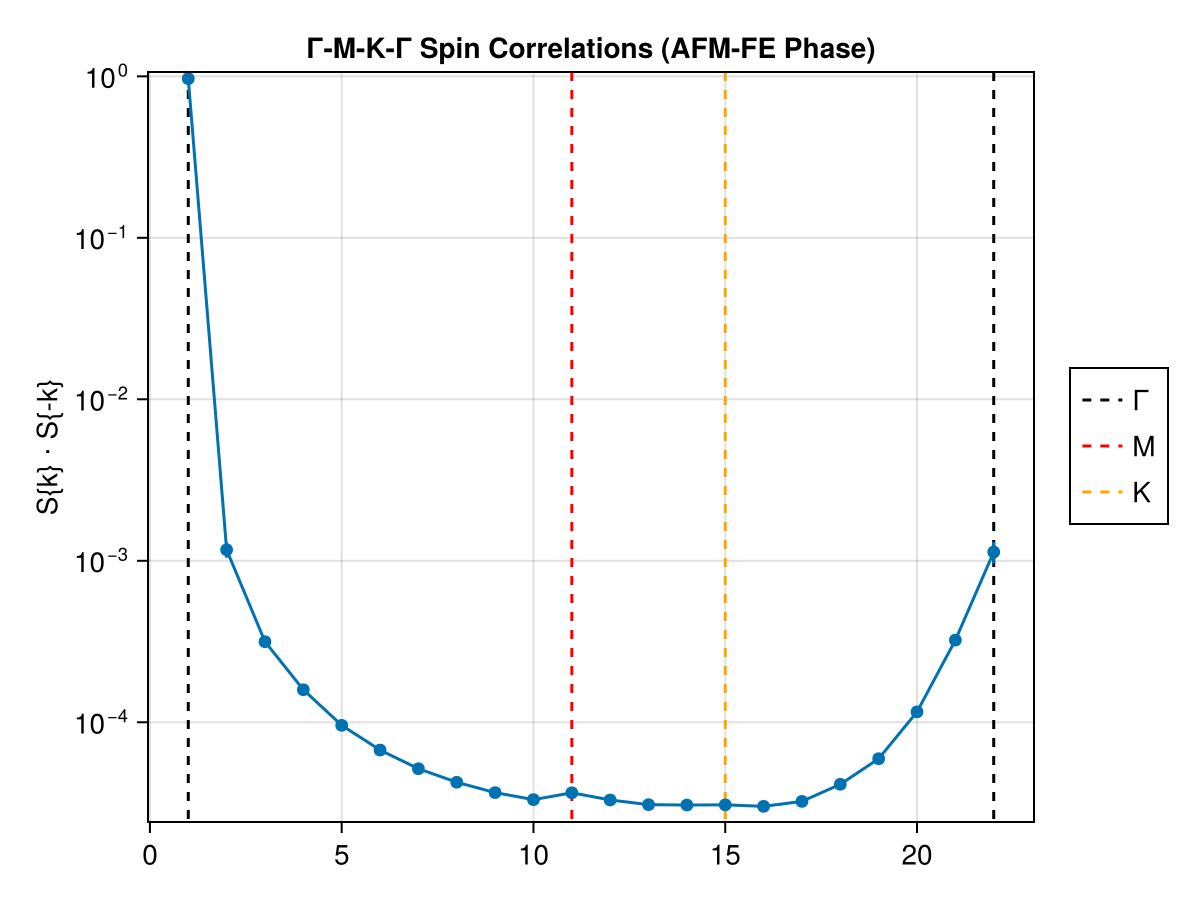

In [31]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])

path = []
pos = (1, 1)
push!(path, pos)
while pos[2] > -div(Ly, 2) + 1
    pos = pos .+ (-1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
M_pos = length(path)
while pos[1] < -div(Lx, 3) + 1
    pos = pos .+ (1, -1)
    push!(path, mod1.(pos, (Lx, Ly)))
end
K_pos = length(path)
while pos[2] < 1
    pos = pos .+ (1, 2)
    push!(path, mod1.(pos, (Lx, Ly)))
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (AFM-FE Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)

for i in [1]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs)
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (0.8 * min_corr, 1.1 * max_corr))
Legend(fig[1,2], ax)
fig

In [32]:
CairoMakie.activate!()

i = 7
Lx = 40
etak_corrs = bias_results[:etak_corrs]
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorrange=(0, max_corrs.val))
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

ArgumentError: ArgumentError: column name :etak_corrs not found in the data frame

In [33]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Bs = bias_results[:B]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 9]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = bias_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="B=$(Bs[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

ArgumentError: ArgumentError: column name "ηk_xx" not found in the data frame; existing most similar names are: "ηk_M" and "ηk_Γ"

## Annealed Random Initial State

In [ ]:
anneal_results = JobResult("../jobs", "fm-anneal")
separate_etaks!(anneal_results.data)

JobResult("../jobs", "fm-anneal", 42×37 DataFrame
 Row │ ηz               T        init_T   etak_corrs                         _ ⋯
     │ Measurem…        Float64  Float64  Array…                             M ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.988915±6.8e-5      0.5     10.0  Complex{Measurement{Float64}}[1.…  0 ⋯
   2 │ 0.977365±9.3e-5      1.0     10.0  Complex{Measurement{Float64}}[2.…  0
   3 │ 0.96511±0.00016      1.5     10.0  Complex{Measurement{Float64}}[4.…  0
   4 │ 0.95231±0.00015      2.0     10.0  Complex{Measurement{Float64}}[5.…  0
   5 │ 0.93816±0.00016      2.5     10.0  Complex{Measurement{Float64}}[7.…  0 ⋯
   6 │ 0.92315±0.00015      3.0     10.0  Complex{Measurement{Float64}}[9.…  0
   7 │ 0.90665±0.00022      3.5     10.0  Complex{Measurement{Float64}}[0.…  0
   8 │ 0.88687±0.00022      4.0     10.0  Complex{Measurement{Float64}}[0.…  0
  ⋮  │        ⋮            ⋮        ⋮                     ⋮            

In [20]:
anneal_results[[:_ll_sweep_time, :_ll_measure_time]]

42×2 DataFrame
 Row │ _ll_sweep_time     _ll_measure_time 
     │ Measurement…       Measurement…     
─────┼─────────────────────────────────────
   1 │ 0.0003977±6.9e-6   0.00017±1.3e-5
   2 │ 0.0004003±7.9e-6   0.000171±1.3e-5
   3 │ 0.0004021±8.0e-6   0.00017±1.2e-5
   4 │ 0.0004026±6.9e-6   0.00017±1.1e-5
   5 │ 0.0004036±8.2e-6   0.00017±1.1e-5
   6 │ 0.0004159±8.3e-6   0.000172±1.2e-5
   7 │ 0.0004049±7.7e-6   0.000172±1.3e-5
   8 │ 0.0004021±7.5e-6   0.000169±1.2e-5
  ⋮  │         ⋮                 ⋮
  36 │ 0.00664967±8.6e-7  0.0021593±3.4e-6
  37 │ 0.00667253±5.6e-7  0.0021664±3.6e-6
  38 │ 0.00666137±7.8e-7  0.0021605±3.4e-6
  39 │ 0.0066796±1.5e-6   0.0021546±3.5e-6
  40 │ 0.0067536±1.9e-6   0.0021639±3.7e-6
  41 │ 0.0067493±8.6e-7   0.0021608±3.5e-6
  42 │ 0.0067405±1.3e-6   0.0021657±3.6e-6
                            27 rows omitted

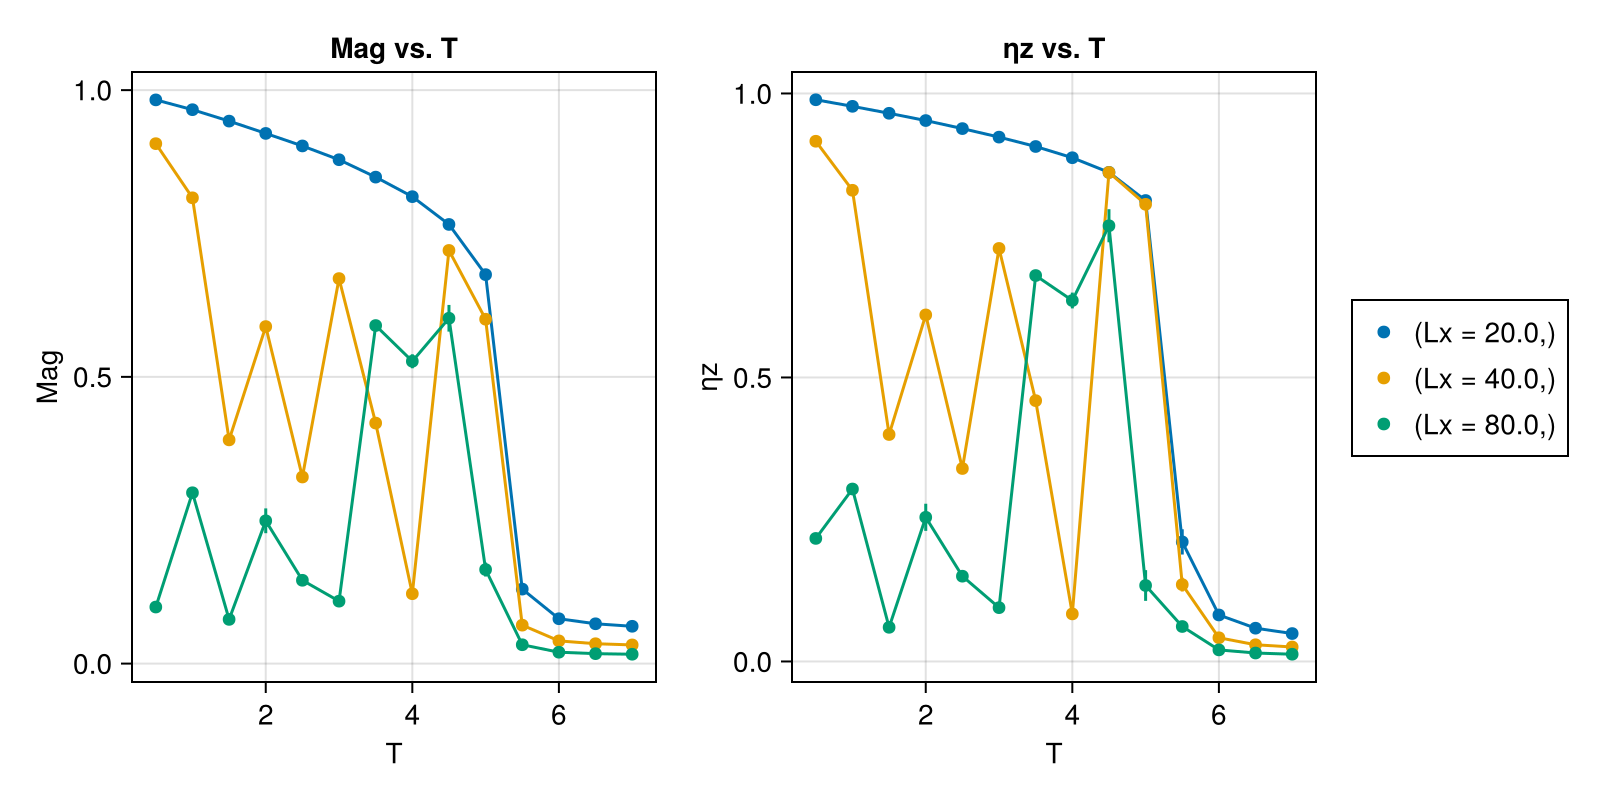

In [41]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
gd = groupby(anneal_results.data, :Lx)
fig[1,1] = ax_s = Axis(fig, title="Mag vs. T", xlabel="T", ylabel="Mag")
generate_plot!(ax_s, :T, :Mag, gd; line=true)
fig[1,2] = ax_η = Axis(fig, title="ηz vs. T", xlabel="T", ylabel="ηz")
generate_plot!(ax_η, :T, :ηz, gd; line=true)
Legend(fig[1,3], ax_η)
fig

In [22]:
anneal_mctimes = get_mctime_data(anneal_results, :Mag, :Magx, :Magy, :Magz, :ηz)

42-element Vector{DataFrame}:
 100×5 DataFrame
 Row │ Mag             Magx            Magy             Magz            ηz     ⋯
     │ SubArray…       SubArray…       SubArray…        SubArray…       SubArr ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ fill(0.978726)  fill(0.801445)  fill(-0.508691)  fill(0.238196)  fill(0 ⋯
   2 │ fill(0.981194)  fill(0.802446)  fill(-0.507376)  fill(0.247706)  fill(0
   3 │ fill(0.983794)  fill(0.796567)  fill(-0.520992)  fill(0.248656)  fill(0
   4 │ fill(0.983284)  fill(0.792156)  fill(-0.524233)  fill(0.253888)  fill(0
   5 │ fill(0.982832)  fill(0.799648)  fill(-0.508615)  fill(0.260346)  fill(0 ⋯
   6 │ fill(0.98257)   fill(0.80899)   fill(-0.489573)  fill(0.2668)    fill(0
   7 │ fill(0.984087)  fill(0.803345)  fill(-0.489828)  fill(0.287924)  fill(0
   8 │ fill(0.982975)  fill(0.787024)  fill(-0.5058)    fill(0.301507)  fill(0
  ⋮  │       ⋮               ⋮                ⋮               ⋮           

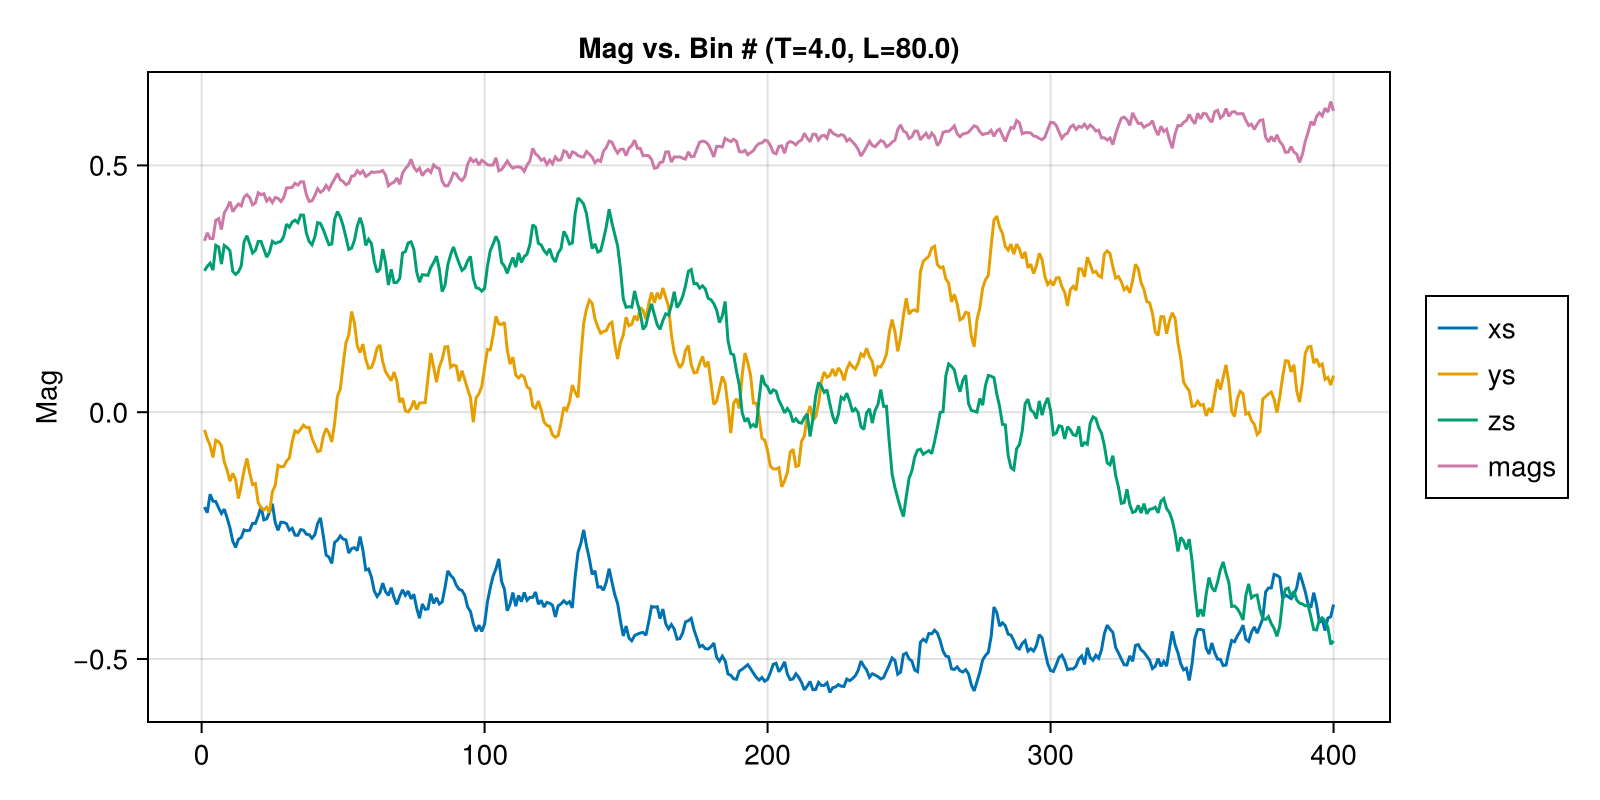

In [23]:
i = 36
mctimes = anneal_mctimes[i][:, [:Mag, :Magx, :Magy, :Magz]]

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(
    fig,
    title="Mag vs. Bin # (T=$(anneal_results.data[i, :T]), L=$(anneal_results.data[i, :Lx]))",
    ylabel="Mag"
)
mags = first.(mctimes[:, :Mag])
xs = first.(mctimes[:, :Magx])
ys = first.(mctimes[:, :Magy])
zs = first.(mctimes[:, :Magz])
lines!(ax1, xs, label="xs")
lines!(ax1, ys, label="ys")
lines!(ax1, zs, label="zs")
lines!(ax1, mags, label="mags")
Legend(fig[1,2], ax1)
fig

In [24]:
spink_corrs = anneal_results[:spink_corrs]

42-element Vector{Matrix{Measurements.Measurement{Float64}}}:
 [0.96635 ± 0.00056 0.00137 ± 0.00017 … 0.000329 ± 1.7e-5 0.00137 ± 0.00017; 0.00138 ± 0.00018 0.001301 ± 9.8e-5 … 0.0002 ± 1.1e-5 0.000438 ± 3.9e-5; … ; 0.000353 ± 2.1e-5 0.000205 ± 1.2e-5 … 0.000341 ± 2.5e-5 0.0005 ± 3.8e-5; 0.00138 ± 0.00018 0.000438 ± 3.9e-5 … 0.000445 ± 4.9e-5 0.001301 ± 9.8e-5]
 [0.933 ± 0.0013 0.0025 ± 0.00033 … 0.000619 ± 3.2e-5 0.0025 ± 0.00033; 0.00229 ± 0.00018 0.00283 ± 0.00023 … 0.000429 ± 1.9e-5 0.000841 ± 5.4e-5; … ; 0.000736 ± 4.1e-5 0.000402 ± 2.5e-5 … 0.000732 ± 3.8e-5 0.000983 ± 6.7e-5; 0.00229 ± 0.00018 0.000841 ± 5.4e-5 … 0.000925 ± 5.7e-5 0.00283 ± 0.00023]
 [0.895 ± 0.00072 0.00425 ± 0.00035 … 0.001036 ± 4.0e-5 0.00425 ± 0.00035; 0.00429 ± 0.0004 0.00386 ± 0.00041 … 0.000681 ± 2.2e-5 0.001579 ± 8.7e-5; … ; 0.001068 ± 4.3e-5 0.00062 ± 2.5e-5 … 0.001089 ± 3.3e-5 0.001477 ± 7.3e-5; 0.00429 ± 0.0004 0.001579 ± 8.7e-5 … 0.0014 ± 7.6e-5 0.00386 ± 0.00041]
 [0.8549 ± 0.0015 0.00598 ± 0.00039 

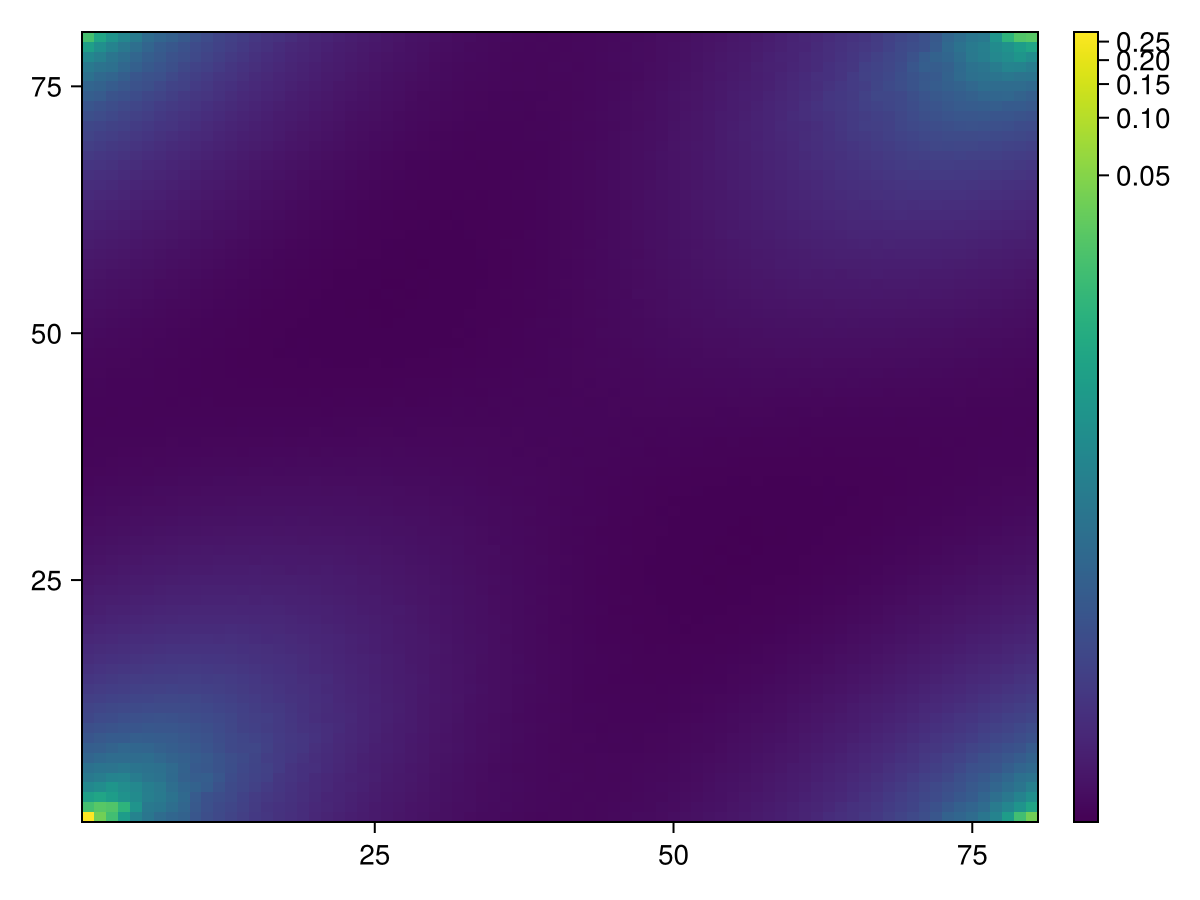

In [25]:
CairoMakie.activate!()
fig = Figure(size=(500, 500))
ax = fig[1,1] = Axis(fig; title="Spin_k")
scale = ReversibleScale(log)
fig, ax, hm = heatmap(getfield.(spink_corrs[36], :val), colorscale=scale)
Colorbar(fig[1, 2], hm)
fig

Any[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 5), (13, 7), (11, 6), (9, 5), (7, 4), (5, 3), (3, 2), (1, 1)]


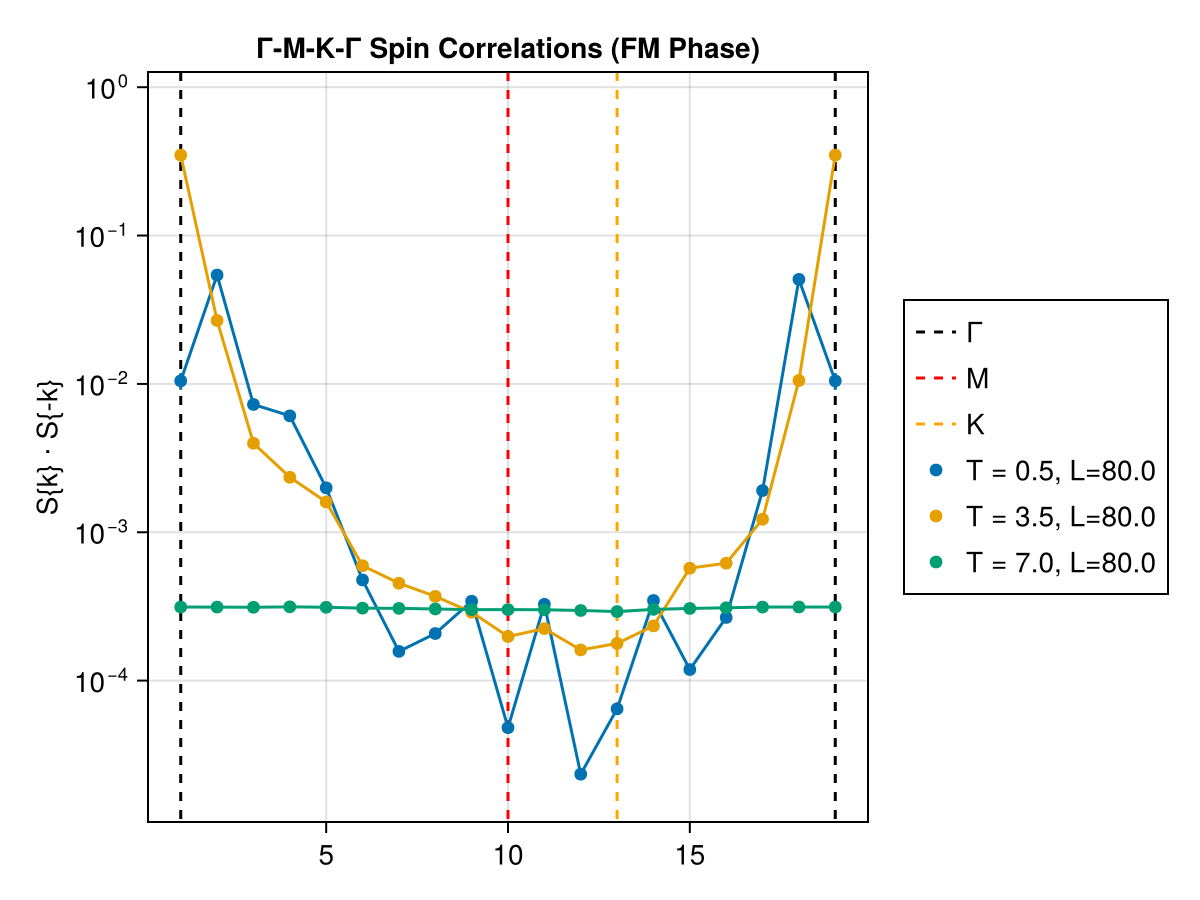

In [26]:
CairoMakie.activate!()
Lx, Ly = size(spink_corrs[1])
borderx = div(Lx, 2) + 1
bordery = div(Ly, 2) + 1

path = []
pos = (1, 1)
push!(path, pos)
while pos[1] < div(Lx, 2)
    pos = pos .+ (1, 0)
    push!(path, pos)
end
M_pos = length(path)
while pos[2] < div(Ly, 3)
    pos = pos .+ (1, 2)
    push!(path, pos)
end
K_pos = length(path)
while pos[2] > 1
    pos = pos .- (2, 1)
    push!(path, pos)
end
println(path)

fig = Figure()
fig[1, 1] = ax = Axis(
    fig,
    title="Γ-M-K-Γ Spin Correlations (FM Phase)",
    ylabel="S{k} ⋅ S{-k}",
    yscale=log10
)

min_corr = minimum(getfield.([spink_corrs[1][I...] for I in path], :val))
max_corr = maximum(getfield.([spink_corrs[1][I...] for I in path], :val))
lines!([(1, 2), (1, 1e-9)], color=:black, label="Γ", linestyle=:dash)
lines!([(M_pos, 2), (M_pos, 1e-9)], color=:red, label="M", linestyle=:dash)
lines!([(K_pos, 2), (K_pos, 1e-9)], color=:orange, label="K", linestyle=:dash)
lines!([(length(path), 2), (length(path), 1e-9)], color=:black, linestyle=:dash)
for i in [29, 35, 42]
    corrs = [spink_corrs[i][I...] for I in path]
    scatter!(ax, corrs, label="T = $(anneal_results.data[i, :T]), L=$(anneal_results.data[i, :Lx])")
    errorbars!(ax, 1:length(path), getfield.(corrs, :val), getfield.(corrs, :err))
    lines!(ax, corrs)
end

ylims!(ax, (min_corr - 2e-5, max_corr + 0.3))
Legend(fig[1,2], ax)
fig

In [27]:
etak_corrs = anneal_results[:etak_corrs]

42-element Vector{Array{Complex{Measurements.Measurement{Float64}}, 4}}:
 [1.367e-5 ± 7.7e-7 + 0.0 ± 0.0im 1.433e-5 ± 5.5e-7 + 0.0 ± 0.0im … 1.404e-5 ± 4.9e-7 + 0.0 ± 0.0im 1.433e-5 ± 5.5e-7 + 0.0 ± 0.0im; 1.384e-5 ± 5.4e-7 + 0.0 ± 0.0im 1.369e-5 ± 3.5e-7 + 0.0 ± 0.0im … 1.539e-5 ± 4.8e-7 + 0.0 ± 0.0im 1.384e-5 ± 4.3e-7 + 0.0 ± 0.0im; … ; 1.52e-5 ± 5.9e-7 + 0.0 ± 0.0im 1.554e-5 ± 6.2e-7 + 0.0 ± 0.0im … 1.489e-5 ± 5.5e-7 + 0.0 ± 0.0im 1.514e-5 ± 6.4e-7 + 0.0 ± 0.0im; 1.384e-5 ± 5.4e-7 + 0.0 ± 0.0im 1.384e-5 ± 4.3e-7 + 0.0 ± 0.0im … 1.445e-5 ± 4.8e-7 + 0.0 ± 0.0im 1.369e-5 ± 3.5e-7 + 0.0 ± 0.0im;;; 8.6e-8 ± 3.4e-7 + 0.0 ± 0.0im -1.8e-8 ± 5.2e-7 + 2.1304290069584142e-7 ± 0.0im … 8.3e-7 ± 5.4e-7 - 6.899888067264932e-8 ± 0.0im -1.8e-8 ± 5.2e-7 - 2.1304290069584142e-7 ± 0.0im; -4.0e-7 ± 5.9e-7 - 1.9161447833852976e-7 ± 0.0im -5.7e-7 ± 5.5e-7 - 3.875291742978242e-7 ± 0.0im … -8.2e-7 ± 4.5e-7 + 3.3927217512400027e-7 ± 0.0im -1.0e-7 ± 5.3e-7 + 3.568895942701436e-7 ± 0.0im; … ; -3.7e-7 ± 4.0e-7 

Maximum correlation norm: 0.1097314 ± 4.8e-6

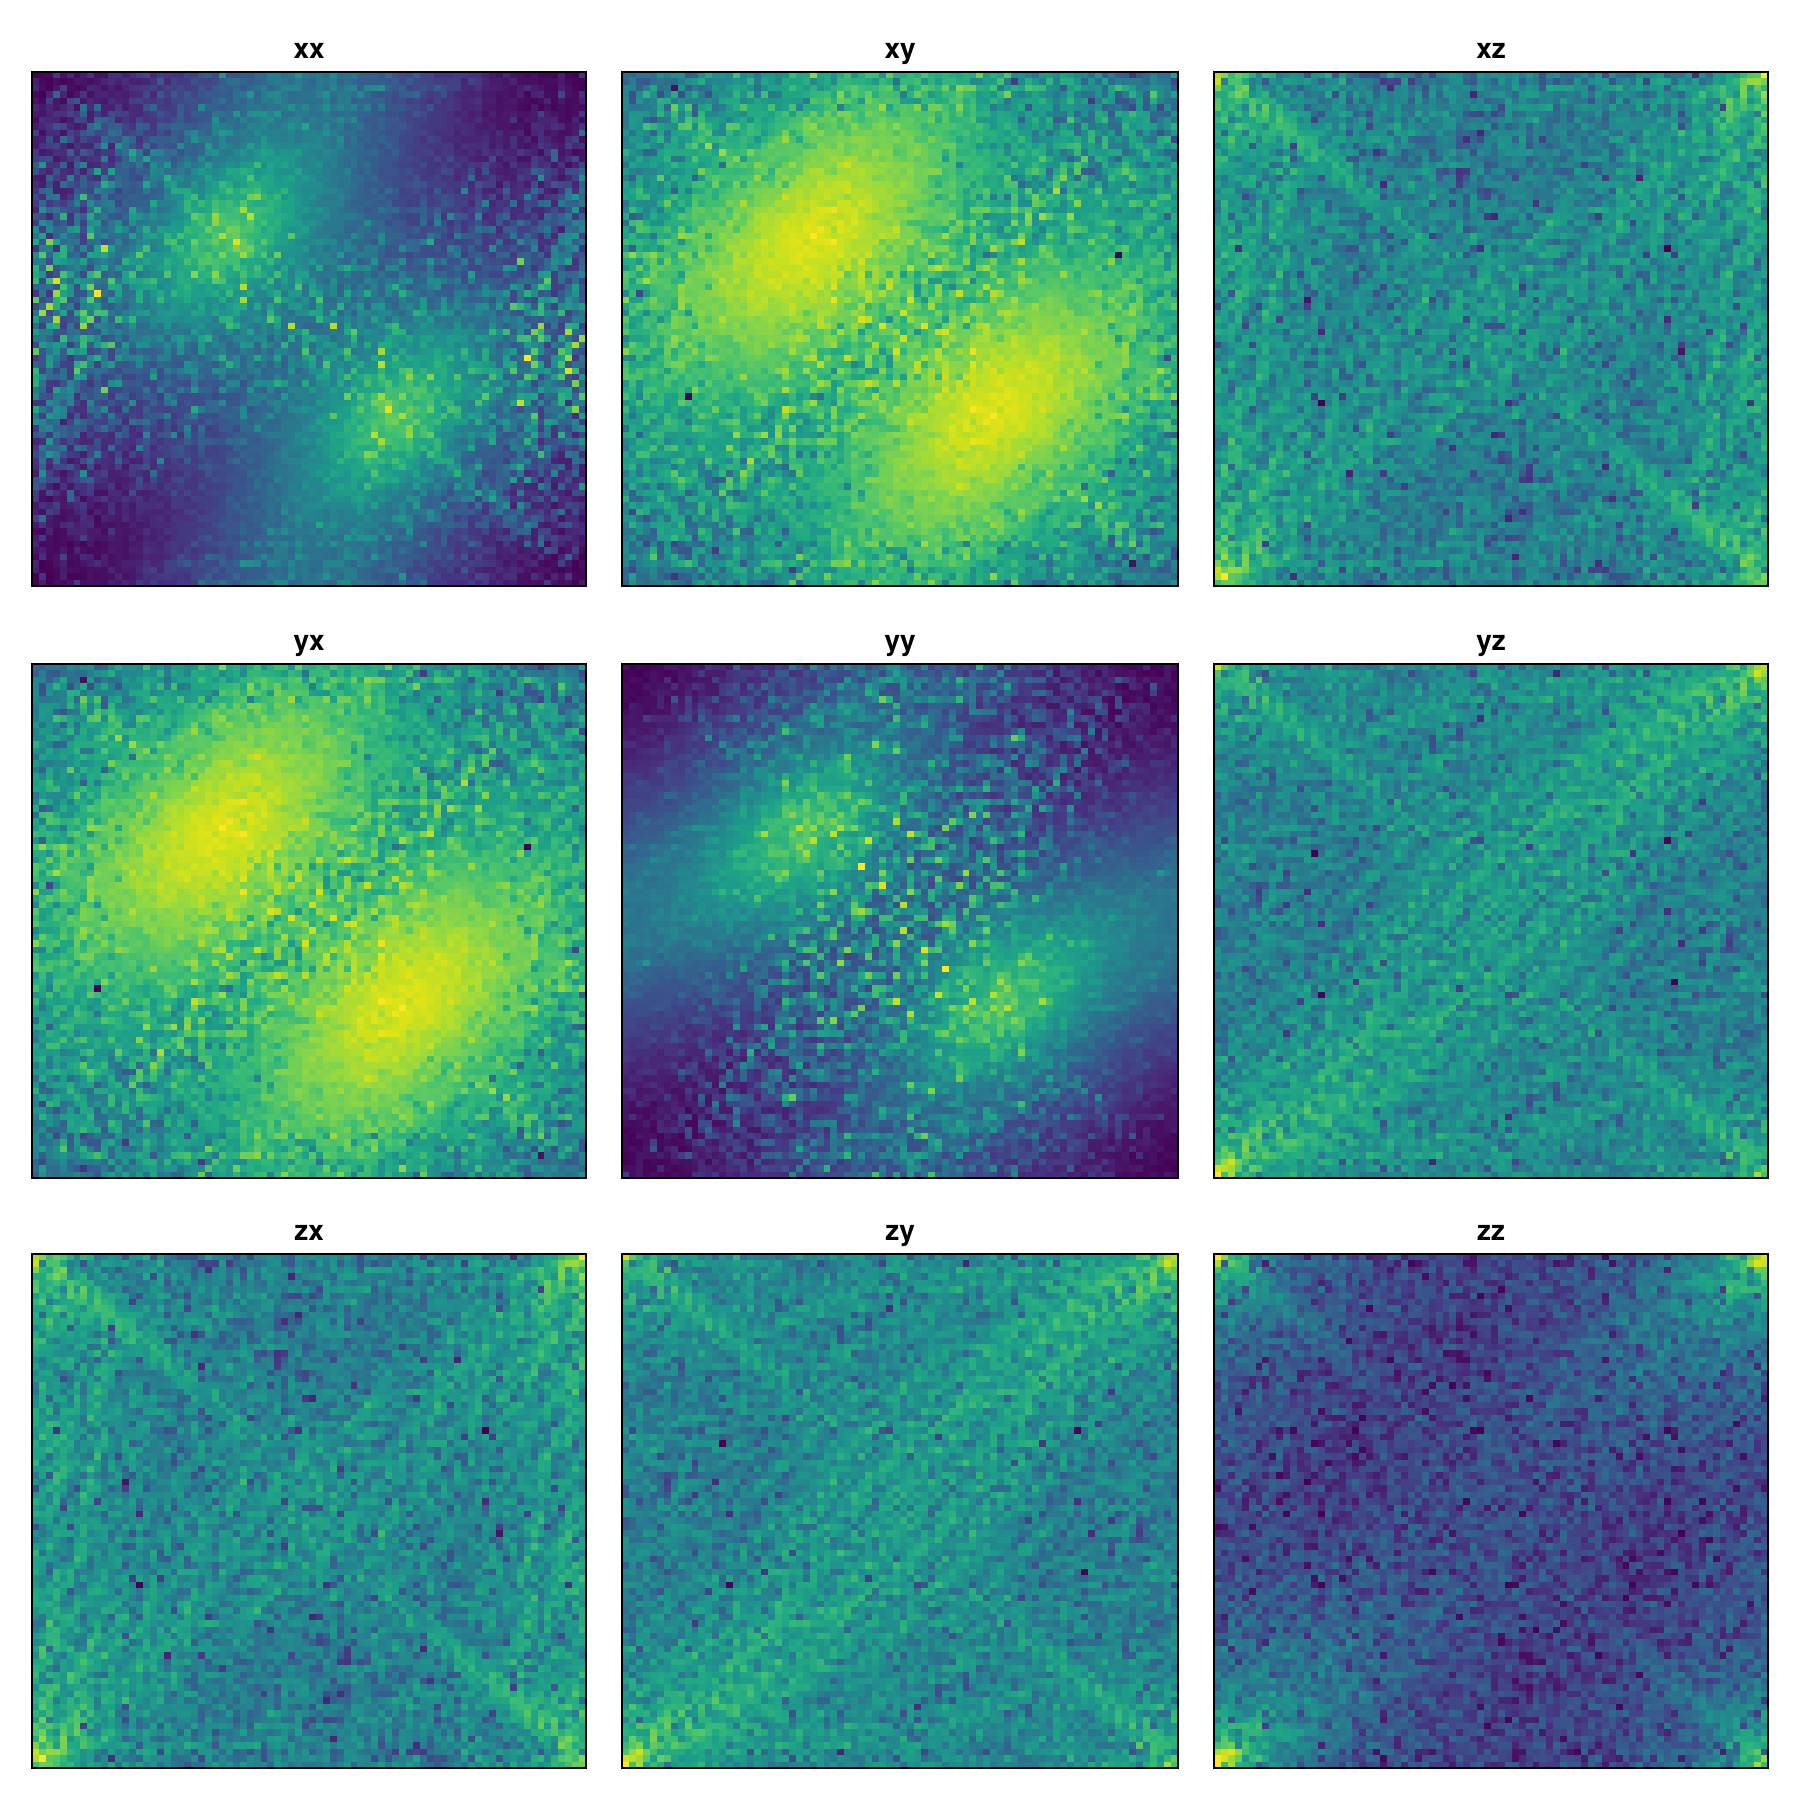

In [28]:
CairoMakie.activate!()

i = 30
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
scale = ReversibleScale(log)
corr_matrices = eachslice(etak_corrs[i], dims=(1, 2))
max_corrs = maximum(abs.(etak_corrs[i]))
min_corrs = minimum(abs.(etak_corrs[i]))
for x in 1:3
    for y in 1:3
        fig[x, y] = ax = Axis(fig, title="$(labels[x])$(labels[y])")
        corrs = getindex.(corr_matrices, x, y)
        heatmap!(ax, getfield.(abs.(corrs), :val), colorscale=scale)
        hidedecorations!(ax)
    end
end

print("Maximum correlation norm: $max_corrs")
fig

In [29]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Ts = anneal_results[:T]
Ls = anneal_results[:Lx]
scale = ReversibleScale(log)

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])", yscale=scale)
    end
end

is = [29, 35, 37]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = anneal_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = [abs(corr_matrices[i][I...]) for I in path for i in is]
    min_corr = minimum(getfield.(all_corrs, :val))
    min_border = 0.9 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 1.1 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = [corr_matrix[I...] for I in path]
        corr_vals = getfield.(abs.(corrs), :val)
        corr_errs = getfield.(abs.(corrs), :err)
        scatter!(ax, corr_vals, label="T=$(Ts[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

## Annealed Bias Field

In [7]:
bias_results = JobResult("../jobs", "fm-bias")
bias_results

JobResult("../jobs", "fm-bias", 99×44 DataFrame
 Row │ ηk_Γ                               Magx              ηy                 ⋯
     │ Array…                             Measurem…         Measurem…          ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Complex{Measurement{Float64}}[-0…  -0.066±0.12        0.00032±0.00024   ⋯
   2 │ Complex{Measurement{Float64}}[-0…   0.0027±0.01       9.0e-5±0.00015
   3 │ Complex{Measurement{Float64}}[-7…  -0.0065±0.0058     9.3e-5±0.00015
   4 │ Complex{Measurement{Float64}}[9.…  -0.0049±0.0029    -2.9e-5±0.00025
   5 │ Complex{Measurement{Float64}}[-1…   0.0032±0.0029     0.00018±0.00018   ⋯
   6 │ Complex{Measurement{Float64}}[6.…   0.00042±0.0028   -0.00044±0.00016
   7 │ Complex{Measurement{Float64}}[-7…  -0.0041±0.0012    -3.5e-5±0.00015
   8 │ Complex{Measurement{Float64}}[0.…  -8.6e-6±0.0021    -0.0002±0.00018
  ⋮  │                 ⋮                         ⋮                 ⋮           ⋱
  93 │ Co

In [8]:
bias_results[[:_ll_sweep_time, :_ll_measure_time]]

99×2 DataFrame
 Row │ _ll_sweep_time    _ll_measure_time 
     │ Measurement…      Measurement…     
─────┼────────────────────────────────────
   1 │ 0.0003928±1.8e-6  0.000186±1.8e-5
   2 │ 0.0003943±2.0e-6  0.000171±2.5e-5
   3 │ 0.00047±1.1e-5    0.000213±2.7e-5
   4 │ 0.0003936±1.9e-6  0.000186±2.7e-5
   5 │ 0.000453±1.3e-5   0.00021±2.5e-5
   6 │ 0.000471±1.2e-5   0.000216±2.5e-5
   7 │ 0.00041±1.1e-5    0.000188±1.7e-5
   8 │ 0.000444±1.4e-5   0.000191±2.5e-5
  ⋮  │        ⋮                 ⋮
  93 │ 0.005804±6.3e-6   0.0015103±3.6e-6
  94 │ 0.005783±7.0e-6   0.0015125±2.8e-6
  95 │ 0.0057692±6.2e-6  0.0015022±2.9e-6
  96 │ 0.0057897±8.9e-6  0.0015109±3.2e-6
  97 │ 0.0057921±8.1e-6  0.0015101±3.0e-6
  98 │ 0.0057704±8.1e-6  0.0015091±3.3e-6
  99 │ 0.005786±1.1e-5   0.0015206±3.8e-6
                           84 rows omitted

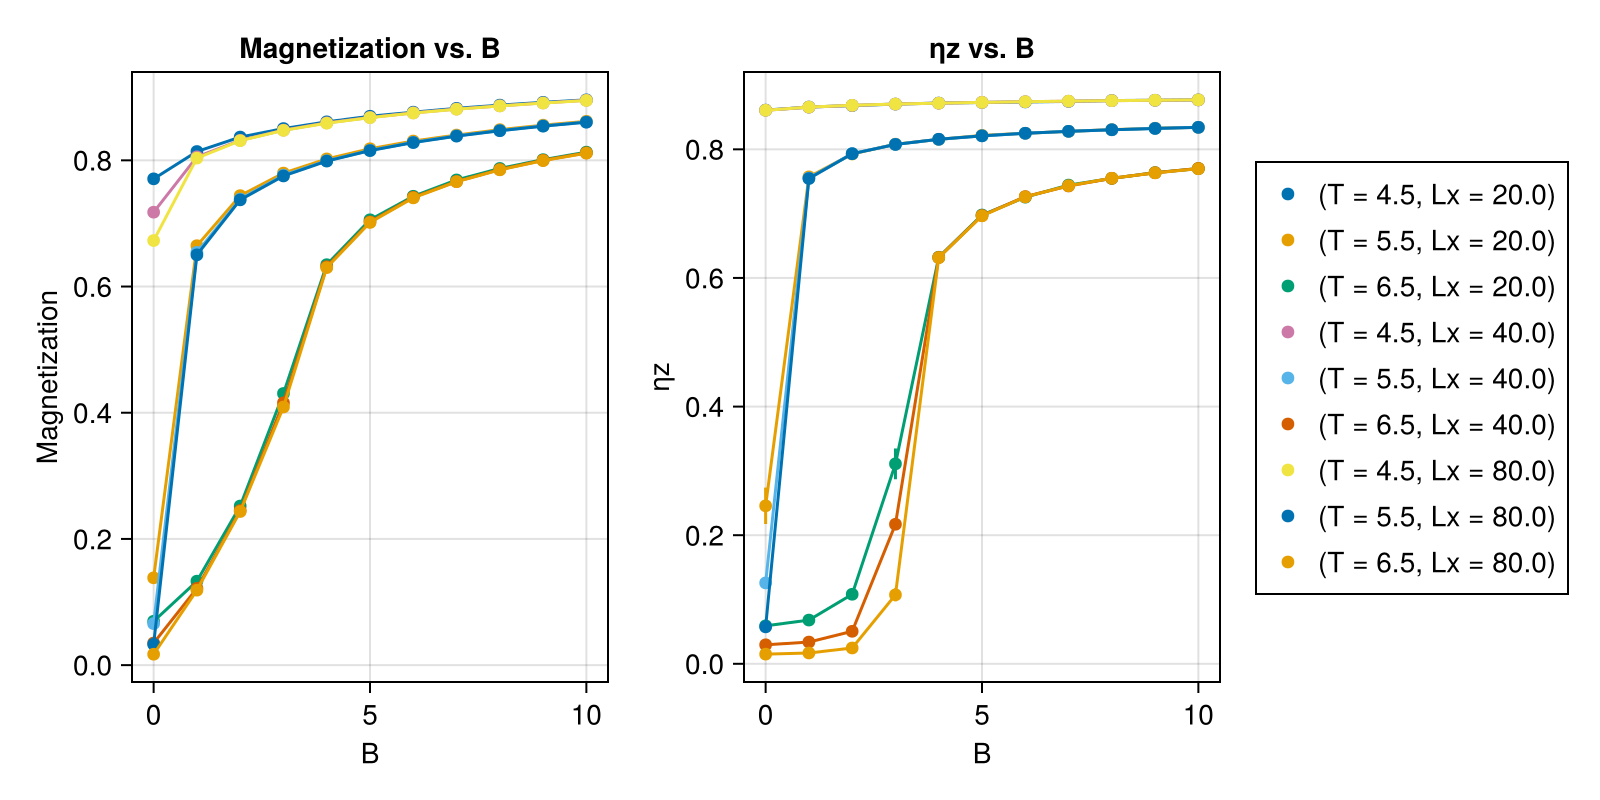

In [9]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Magnetization vs. B", xlabel="B", ylabel="Magnetization")
# scatter!(ax1, bias_results[:B], M_points)
# lines!(ax1, bias_results[:B], M_points)
generate_plot!(ax1, :B, :Mag, [:T, :Lx], bias_results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="ηz vs. B", xlabel="B", ylabel="ηz")
generate_plot!(ax2, :B, :ηz, [:T, :Lx], bias_results.data; line=true)
Legend(fig[1,3], ax2)
fig

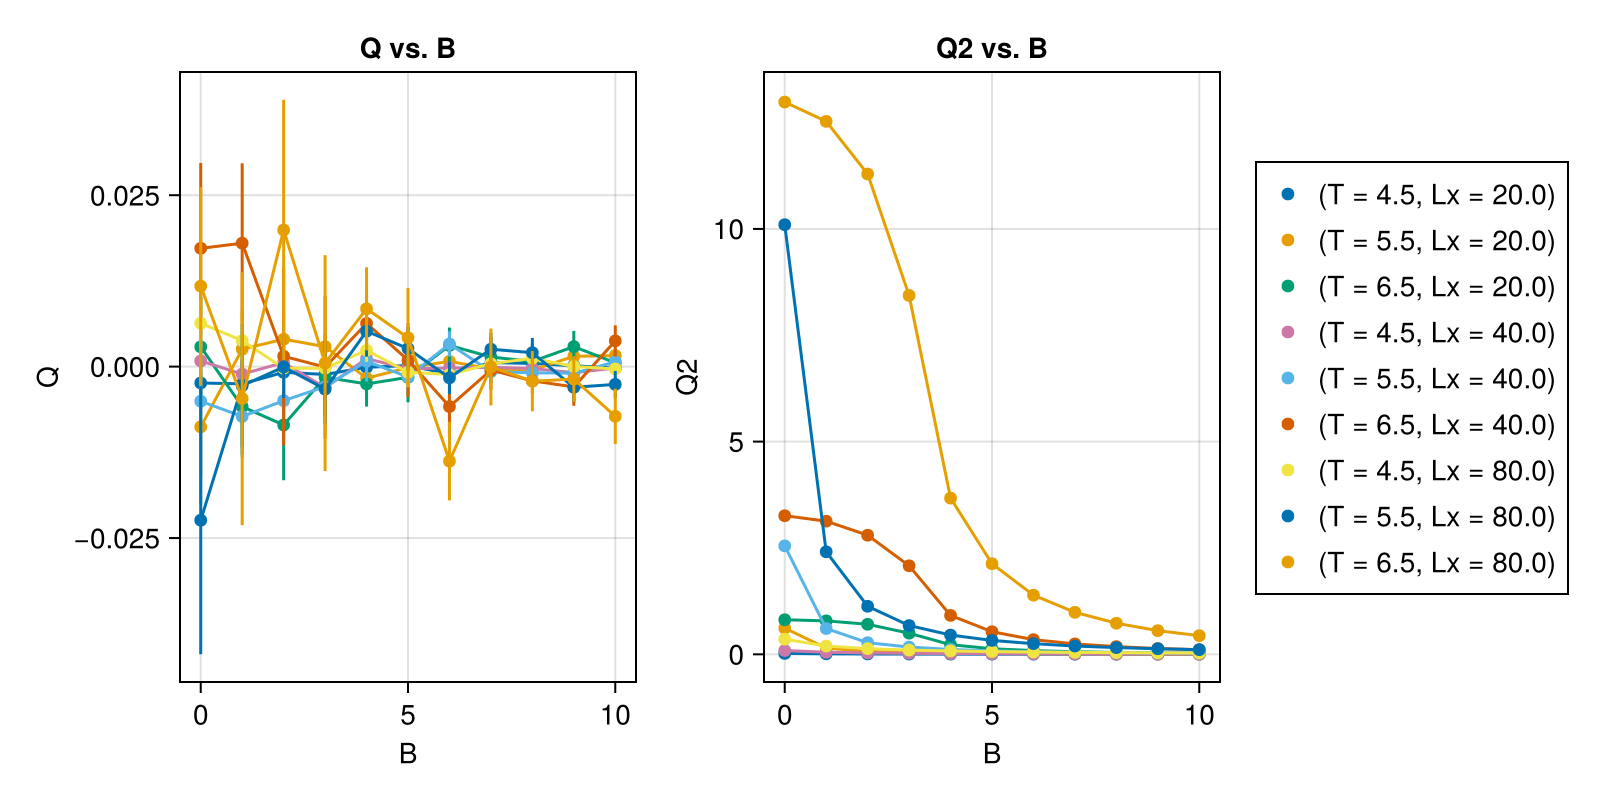

In [15]:
CairoMakie.activate!()

fig = Figure(size=(800, 400))
ax1 = fig[1,1] = Axis(fig, title="Q vs. B", xlabel="B", ylabel="Q")
generate_plot!(ax1, :B, :Q, [:T, :Lx], bias_results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="Q2 vs. B", xlabel="B", ylabel="Q2")
generate_plot!(ax2, :B, :Q2, [:T, :Lx], bias_results.data; line=true)
Legend(fig[1,3], ax2)
fig

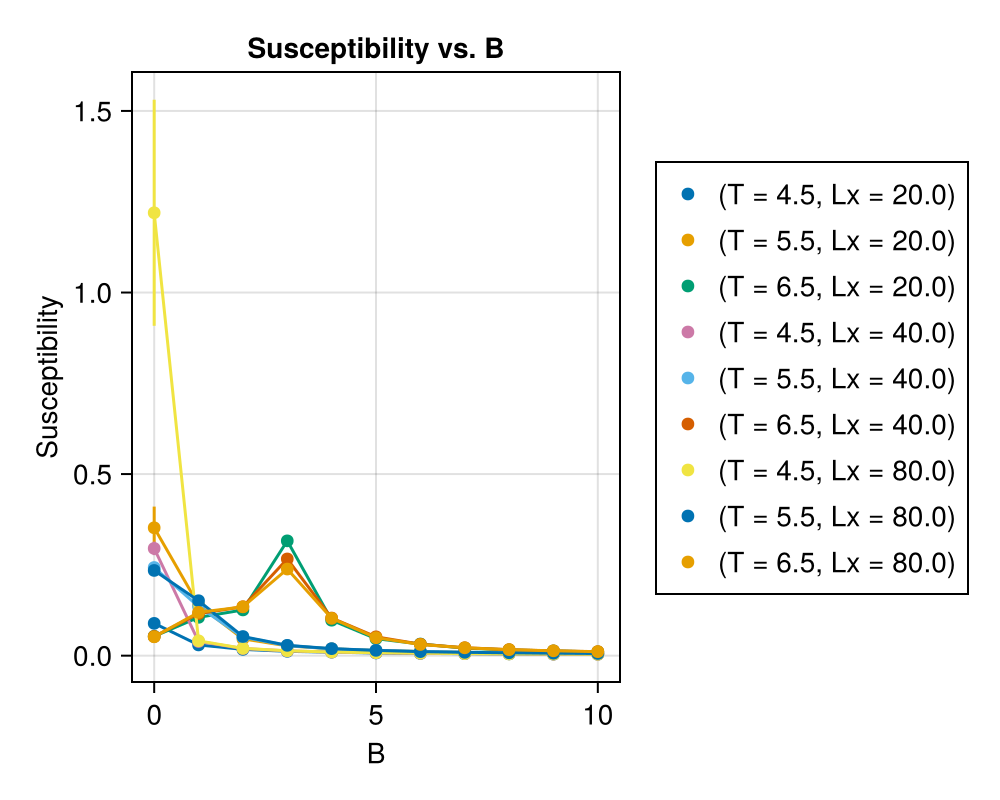

In [16]:
fig = Figure(size=(500, 400))
ax1 = fig[1,1] = Axis(fig, title="Susceptibility vs. B", xlabel="B", ylabel="Susceptibility")
generate_plot!(ax1, :B, :χ, [:T, :Lx], bias_results.data; line=true)
Legend(fig[1,2], ax1)
fig

In [12]:
bias_mctimes = get_mctime_data(bias_results, :Mag, :ηz)
nothing

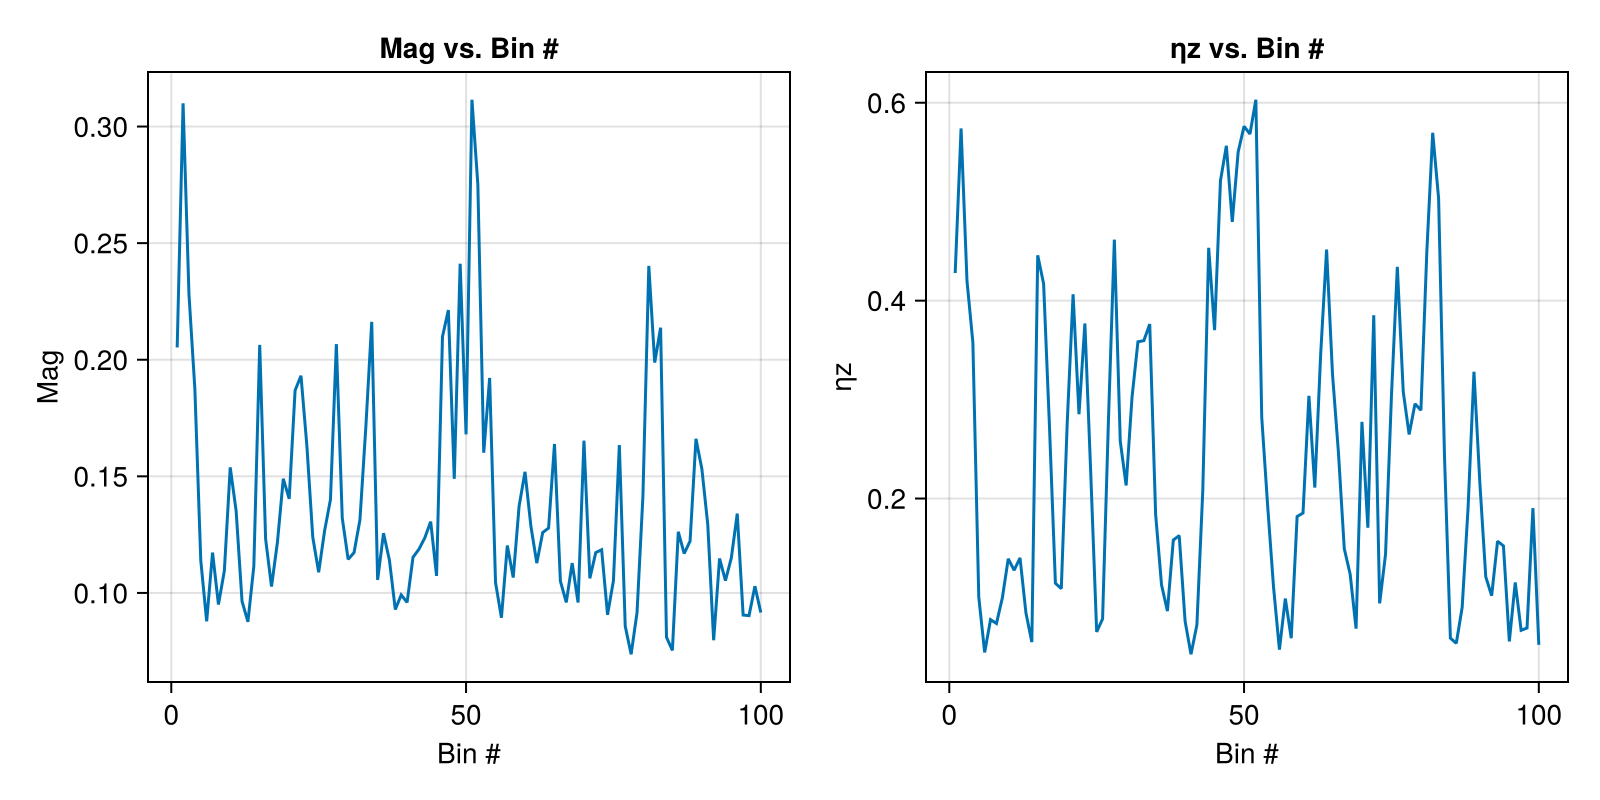

In [13]:
CairoMakie.activate!()
i = 12
k_pos = (1, 1)

var1 = :Mag
var2 = :ηz
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, abs.(first.(bias_mctimes[i][:, var1])))
lines!(ax2, abs.(first.(bias_mctimes[i][:, var2])))
fig

In [14]:
fig = Figure(size=(900, 900))
labels = [:x, :y, :z]
Bs = bias_results[:B]

axs = Matrix{Axis}(undef, 3, 3)
for x in 1:3
    for y in 1:3
        fig[x, y] = axs[x, y] = Axis(fig, title="$(labels[x])$(labels[y])")
    end
end

is = [1, 5, 10]
for (x, y) in Iterators.product(1:3, 1:3)
    ax = axs[x, y]

    corr_matrices = bias_results["ηk_$(labels[x])$(labels[y])"]
    path, M_pos, K_pos = gen_path(size(corr_matrices[first(is)])...)
    all_corrs = log10.([abs(corr_matrices[i][I...]) for I in path for i in is])
    min_corr = minimum(getfield.(all_corrs, :val) - getfield.(all_corrs, :err))
    min_border = 1.1 * min_corr
    max_corr = maximum(getfield.(all_corrs, :val) + getfield.(all_corrs, :err))
    max_border = 0.9 * max_corr
    lines!(
        ax, [(1, max_border), (1, min_border)],
        color=:black, label="Γ", linestyle=:dash
    )
    lines!(
        ax, [(M_pos, max_border), (M_pos, min_border)],
        color=:red, label="M", linestyle=:dash
    )
    lines!(
        ax, [(K_pos, max_border), (K_pos, min_border)],
        color=:orange, label="K", linestyle=:dash
    )

    for i in is
        corr_matrix = corr_matrices[i]
        corrs = log10.(abs.([corr_matrix[I...] for I in path]))
        corr_vals = getfield.(corrs, :val)
        corr_errs = getfield.(corrs, :err)
        scatter!(ax, corr_vals, label="B=$(Bs[i])")
        lines!(ax, corr_vals)
        errorbars!(ax, 1:length(corr_vals), corr_vals, corr_errs)
    end
    ylims!(ax, (min_border, max_border))
end

Legend(fig[:, 4], axs[1, 1])
fig

ArgumentError: ArgumentError: column name "ηk_xx" not found in the data frame; existing most similar names are: "ηk_M" and "ηk_Γ"